# Generate Discriminator Model Figures

In [1]:
%matplotlib inline

import os
import glob

import pandas as pd
import plotnine as p9
import matplotlib as pyplot
import matplotlib.colors as mcolors
import scipy.stats as ss

In [2]:
# set the constants
critical_val = ss.norm.ppf(0.975)

# End total of label functions for each point
end_points = {
    "DaG": 30,
    "CtD": 22,
    "CbG": 20,
    "GiG": 28,
    "All": 100
}

# set the color scheme
color_names = {
        "turquoise": pd.np.array([27, 158, 119, 255])/255,
        "orange": pd.np.array([217, 95, 2, 255])/255,
        "purple": pd.np.array([117, 112, 179, 255])/255,
        "pink": pd.np.array([231, 41, 138, 255])/255,
        "light-green": pd.np.array([102, 166, 30, 255])/255
    }

color_map = {
        "DaG": color_names["turquoise"],
        "CtD": color_names["orange"],
        "CbG": color_names["purple"],
        "GiG": color_names["pink"],
        "All": color_names["light-green"]
}

In [3]:
disc_data_tree = {
    "DaG": "../../../disease_gene/disease_associates_gene/disc_model_experiment/output/*tsv",
    "CtD": "../../../compound_disease/compound_treats_disease/disc_model_experiment/output/*tsv",
    "GiG": "../../../gene_gene/gene_interacts_gene/disc_model_experiment/output/*tsv",
    "CbG": "../../../compound_gene/compound_binds_gene/disc_model_experiment/output/*tsv"
}

In [4]:
disc_data_frames = {
    rel: {
    os.path.splitext(os.path.basename(file))[0].split("_")[0]:
    pd.read_csv(file, sep="\t")
        for file in glob.glob(disc_data_tree[rel])
    }
    for rel in disc_data_tree
}

# Tune Set

In [5]:
dev_disc_df = pd.concat(
    [
        (
            disc_data_frames[rel]['dev']
            .assign(relation=rel)
            .replace(end_points[rel], 'All')
        )
        for rel in disc_data_frames
    ],
    axis=0
)

In [6]:
dev_disc_df = (
    dev_disc_df
    .groupby(["lf_num", "model", "relation"])
    .agg({
        "auroc": ['mean','std'],
        "aupr": ['mean','std'],
        "lf_num": len
    })
    .fillna(0)
    .reset_index()
)

dev_disc_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ["model", "relation"] else col[0] 
    for col in dev_disc_df.columns.values
]

dev_disc_df = (
    dev_disc_df
    .assign(**{
        'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
        'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
        'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
        'aupr_lower': lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
    })
)
dev_disc_df.head(2)

,lf_num,model,relation,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,disc_model,CbG,0.557143,0.0,0.161955,0.0,1,0.557143,0.557143,0.161955,0.161955
1,0,disc_model,CtD,0.719287,0.0,0.331734,0.0,1,0.719287,0.719287,0.331734,0.331734


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


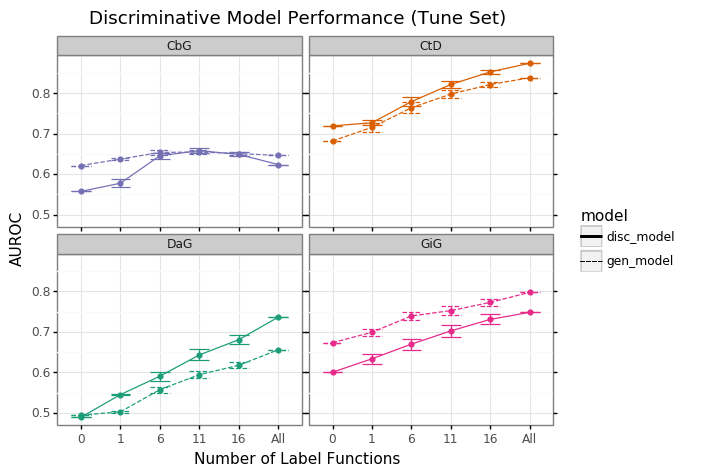

<ggplot: (8729630839009)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../disc_model_dev_auroc.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pack

In [7]:
g = ( 
    p9.ggplot(dev_disc_df, p9.aes(x="factor(lf_num)", y="auroc_mean", linetype="model", color="relation"))
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper"))
    + p9.geom_line(p9.aes(group="model"))
    + p9.scale_x_discrete(limits=[0, 1, 6, 11, 16, 'All'])
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        }, guide=False)
    + p9.facet_wrap("relation")
    + p9.labs(
        title="Discriminative Model Performance (Tune Set)",
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUROC")
    + p9.theme_bw()
)
print(g)
g.save(filename="../disc_model_dev_auroc.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


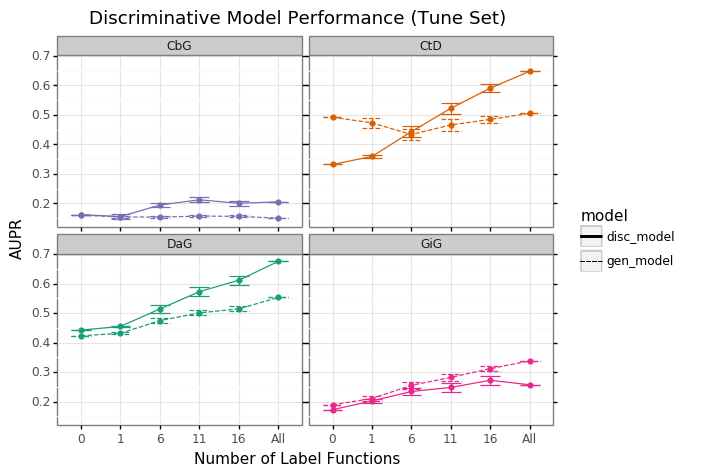

<ggplot: (-9223363307228831849)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../disc_model_dev_aupr.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packa

In [8]:
g = ( 
    p9.ggplot(dev_disc_df, p9.aes(x="factor(lf_num)", y="aupr_mean", linetype="model", color="relation"))
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper"))
    + p9.geom_line(p9.aes(group="model"))
    + p9.scale_x_discrete(limits=[0, 1, 6, 11, 16, 'All'])
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        }, guide=False)
    + p9.facet_wrap("relation")
    + p9.labs(
        title="Discriminative Model Performance (Tune Set)",
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUPR")
    + p9.theme_bw()
)
print(g)
g.save(filename="../disc_model_dev_aupr.png", dpi=300)

# Test Set

In [9]:
test_disc_df = pd.concat(
    [
        (
            disc_data_frames[rel]['test']
            .assign(relation=rel)
            .replace(end_points[rel], 'All')
        )
        for rel in disc_data_frames
    ],
    axis=0
)

In [10]:
test_disc_df = (
    test_disc_df
    .groupby(["lf_num", "model", "relation"])
    .agg({
        "auroc": ['mean','std'],
        "aupr": ['mean','std'],
        "lf_num": len
    })
    .fillna(0)
    .reset_index()
)

test_disc_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ["model", "relation"] else col[0] 
    for col in test_disc_df.columns.values
]

test_disc_df = (
    test_disc_df
    .assign(**{
        'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
        'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
        'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
        'aupr_lower': lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
    })
)
test_disc_df.head(2)

,lf_num,model,relation,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,disc_model,CbG,0.675579,0.0,0.172155,0.0,1,0.675579,0.675579,0.172155,0.172155
1,0,disc_model,CtD,0.719883,0.0,0.402047,0.0,1,0.719883,0.719883,0.402047,0.402047


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


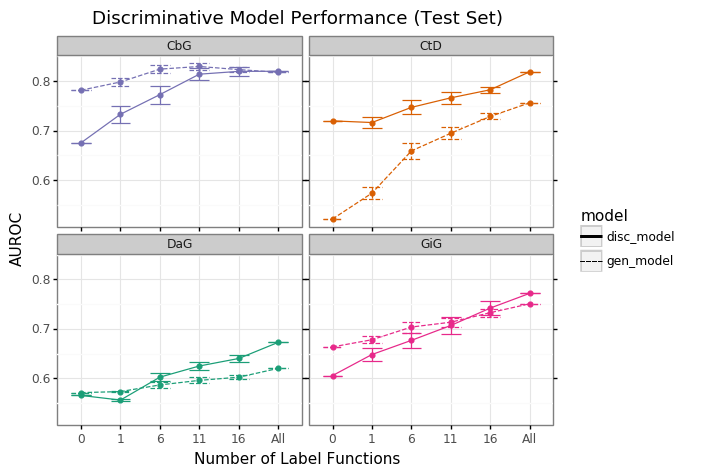

<ggplot: (8729626179392)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../disc_model_test_auroc.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pac

In [11]:
g = ( 
    p9.ggplot(test_disc_df, p9.aes(x="factor(lf_num)", y="auroc_mean", linetype="model", color="relation"))
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper"))
    + p9.geom_line(p9.aes(group="model"))
    + p9.scale_x_discrete(limits=[0, 1, 6, 11, 16, 'All'])
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        }, guide=False)
    + p9.facet_wrap("relation")
    + p9.labs(
        title="Discriminative Model Performance (Test Set)",
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUROC")
    + p9.theme_bw()
)
print(g)
g.save(filename="../disc_model_test_auroc.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


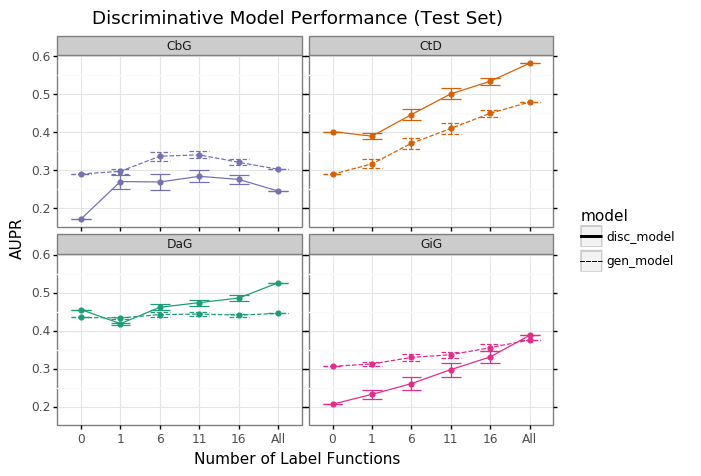

<ggplot: (-9223363307228692080)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../disc_model_test_aupr.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pack

In [12]:
g = ( 
    p9.ggplot(test_disc_df, p9.aes(x="factor(lf_num)", y="aupr_mean", linetype="model", color="relation"))
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper"))
    + p9.geom_line(p9.aes(group="model"))
    + p9.scale_x_discrete(limits=[0, 1, 6, 11, 16, 'All'])
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        }, guide=False)
    + p9.facet_wrap("relation")
    + p9.labs(
        title="Discriminative Model Performance (Test Set)",
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUPR")
    + p9.theme_bw()
)
print(g)
g.save(filename="../disc_model_test_aupr.png", dpi=300)